### about the original h5 file

In [1]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
from petrel_client.client import Client
import io

client = Client(conf_path="~/petreloss.conf")

In [14]:
file_path = 'cluster2:s3://zwl2/RainNet_sp4/2002_07_155.hdf5'
path_root = 'cluster2:s3://zwl2/RainNet_sp4/'
client.contains(file_path)
data = io.BytesIO(client.get(file_path))
f = h5py.File(data, 'r')
high_list = f['highres']
low_list = f['lowres']

In [15]:
high_list.shape, low_list.shape

((624, 999, 4), (208, 333, 4))

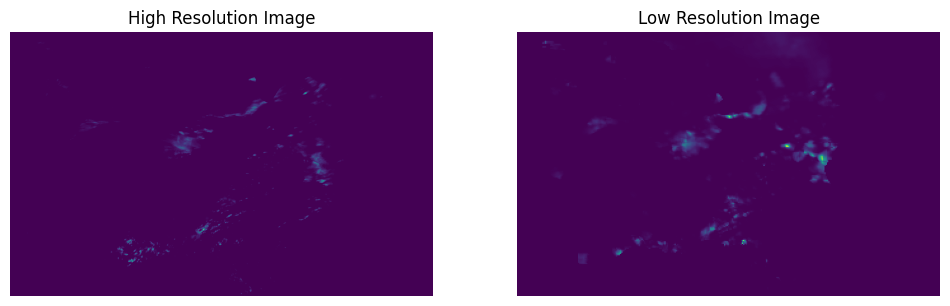

In [16]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.imshow(high_list[:,:,0], cmap='viridis')
plt.title('High Resolution Image')
plt.axis('off') 

plt.subplot(1, 2, 2)
plt.imshow(low_list[:,:,0], cmap='viridis')
plt.title('Low Resolution Image')
plt.axis('off')  

plt.show()

### about pytroch dataset

In [8]:
# get norm in dataset
# Overall high resolution mean:  1.6410927642142792
# Overall high resolution std:  0.7085435655096173
# Overall low resolution mean:  0.5506259077250388
# Overall low resolution std:  0.23751794387367006
# Overall max: 140, Overall minw:0 (According to original code)

import h5py
import torch.utils.data as data
import numpy as np
import cv2
import random
import torch
from PIL import Image, ImageOps
import pandas as pd
import os

from petrel_client.client import Client

client = Client(conf_path="~/petreloss.conf")

class RainNetDataset(data.Dataset):
    def __init__(self,data_path, frame=1, is_crop=True, crop_size_gt=192, upscale_factor=3, is_augment=False ,rotation=False, flip=False):
        # Note crop_size_gt in here is high_resolution image shape[crop_size_gt, crop_size_gt]
        super(RainNetDataset,self).__init__()
        self.highres,self.lowres = RainNet_from_folder(data_path)
        self.len = self.highres.shape[2] - frame + 1
        self.frame = frame
        self.is_crop    = is_crop
        self.crop_size_gt   = crop_size_gt
        self.upscale_factor = upscale_factor
        self.is_augment = is_augment
        self.rotation = rotation
        self.flip     = flip
        
        self.high_res_mean = 1.6412
        self.high_res_std = 0.7085
        self.low_res_mean = 0.5506
        self.low_res_std = 0.2375
        
        self.max = 140.0
        self.min = 0.0

    def __getitem__(self,index):
        if self.frame == 1:
            img_hr = self.highres[:,:,index]
            img_lr = self.lowres[:,:,index]
            img_hr = np.expand_dims(img_hr, -1)
            img_lr = np.expand_dims(img_lr, -1)
        else:
            img_hr = self.highres[:, :, index:index + self.frame]
            img_lr = self.lowres[:, :, index:index + self.frame]

        if self.is_crop:
            # random crop
            img_hr, img_lr = random_crop(img_hr, img_lr, self.crop_size_gt, self.upscale_factor)
            
        if self.is_augment:
            # flip, rotation if wanna augment
            img_hr, img_lr = augment([img_hr, img_lr], self.flip, self.rotation)
        
        # There change the batch_channel to shape[0]
        img_hr, img_lr = toTensor([img_hr, img_lr])
        
        # Mean_Std Norm
        # img_hr = (img_hr - self.high_res_mean) / self.high_res_std
        # img_lr = (img_lr - self.low_res_mean) / self.low_res_std
        
        # Max_min Norm:
        img_hr = (img_hr - self.min) / (self.max - self.min)
        img_lr = (img_lr - self.min) / (self.max - self.min)
        

        return img_hr, img_lr

    def __len__(self):
        return self.len
    
# def RainNet_from_folder(folder):
#     h5_path = folder
#     f = h5py.File(h5_path,'r')
#     highres = f['highres']
#     lowres = f['lowres']
#     return highres,lowres
def RainNet_from_folder(folder):
    highres_list = []
    lowres_list = []

    for filename in os.listdir(folder):
        if filename.endswith('.h5'):
            h5_path = os.path.join(folder, filename)
            with h5py.File(h5_path, 'r') as f:
                highres_list.append(f['highres'][:])
                lowres_list.append(f['lowres'][:])

    highres = np.concatenate(highres_list, axis=2)
    lowres = np.concatenate(lowres_list, axis=2)

    return highres, lowres

# This is from original code (Doing random_crop to given shape while upscale_factor=3)
def random_crop(GT_img, LR_img, GT_crop_size,upscale_factor):

    LR_h, LR_w = LR_img.shape[0],LR_img.shape[1]
    LR_crop_size = GT_crop_size//upscale_factor

    ix = np.random.randint(0,LR_h-LR_crop_size-1)
    iy = np.random.randint(0,LR_w-LR_crop_size-1)

    GT_img_crop = GT_img[ix:ix+GT_crop_size, iy:iy+GT_crop_size,:]
    LR_img_crop = LR_img[ix:ix+LR_crop_size, iy:iy+LR_crop_size,:]

    return GT_img_crop, LR_img_crop

def augment(imgs, hflip=True, rotation=True):
    #print(imgs.shape)
    hflip = hflip and random.random() < 0.5
    vflip = rotation and random.random() < 0.5
    rot = rotation and random.random() < 0.5

    def _augument(img):
        if hflip:
            cv2.flip(img, 1, img)
        if vflip:
            cv2.flip(img, 0, img)
        if rot:
            img = img.transpose(1, 0, 2)

        return img
    imgs = [_augument(img) for img in imgs]
    
    return imgs

def toTensor(imgs):

    def _totensor(img):
        img = torch.from_numpy(img.transpose(2, 0, 1))

        img = img.float()
        return img
    if isinstance(imgs, list):
        return [_totensor(img) for img in imgs]
    else:
        return _totensor(imgs)

In [10]:
data_path = '/home/public-workspace/zhouzhiwang/RainNet/newdata/'
# crop 用于对分辨率的裁剪， crop=False不对图像分辨率进行裁剪
dataset = RainNetDataset(data_path, frame=4, is_crop=False)
len(dataset)

737

In [11]:
loader = data.DataLoader(dataset, batch_size=4, shuffle=False)

for data_hr, data_lr in loader:
    test_hr, test_lr = data_hr, data_lr
    print(data_hr.shape)
    print(data_lr.shape)
    break

torch.Size([4, 4, 624, 999])
torch.Size([4, 4, 208, 333])


In [12]:
import matplotlib.pyplot as plt

def vis(high_data, low_data, index):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    img1 = axs[0].imshow(high_data[2, index], cmap='viridis')
    axs[0].set_title(f'High Resolution Image {index}')
    axs[0].axis('off')

    img2 = axs[1].imshow(low_data[2, index], cmap='viridis')
    axs[1].set_title(f'Low Resolution Image {index}')
    axs[1].axis('off')
    
    cbar = fig.colorbar(img1, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)
    cbar.ax.set_xlabel('Precipitation')  

    plt.show()


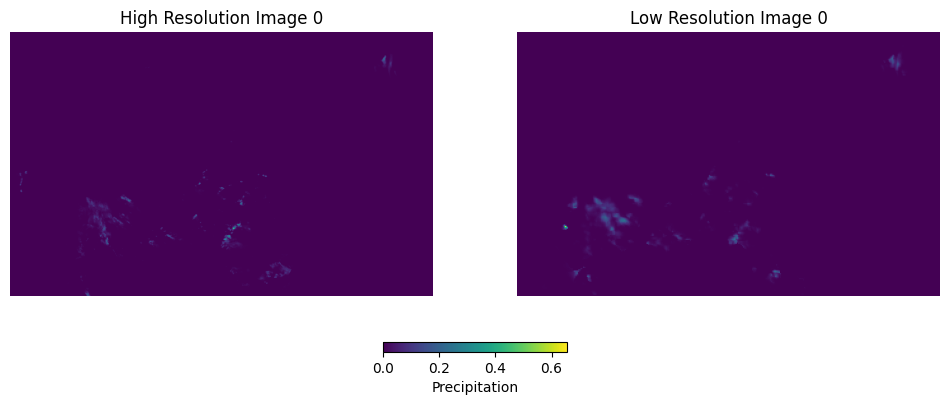

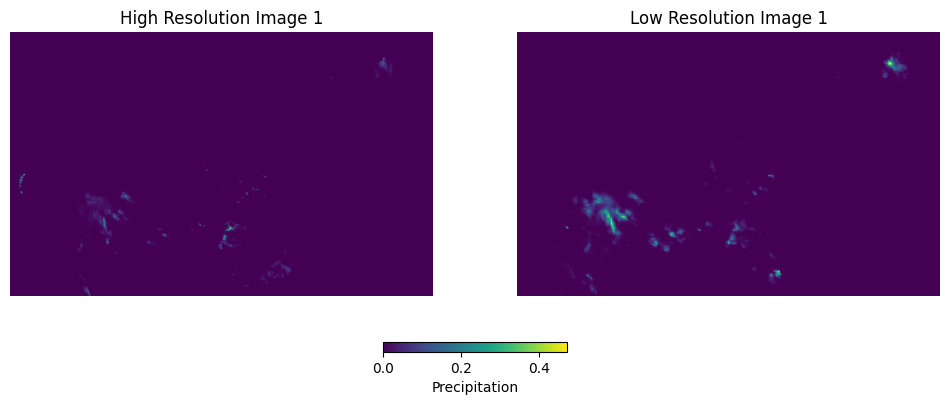

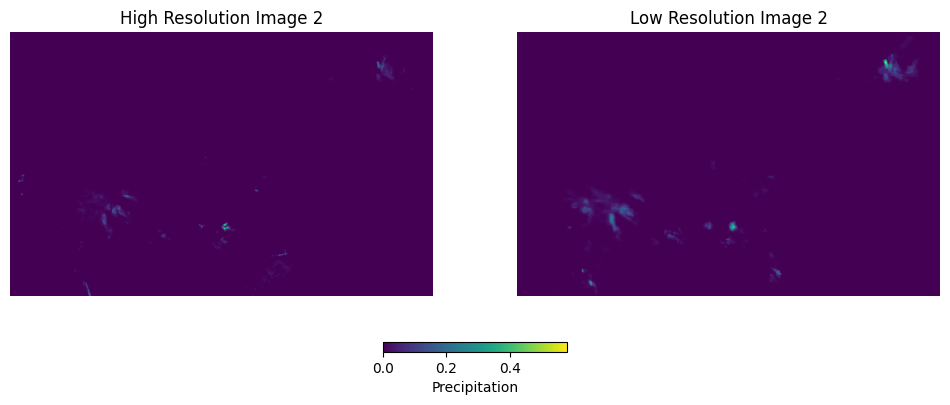

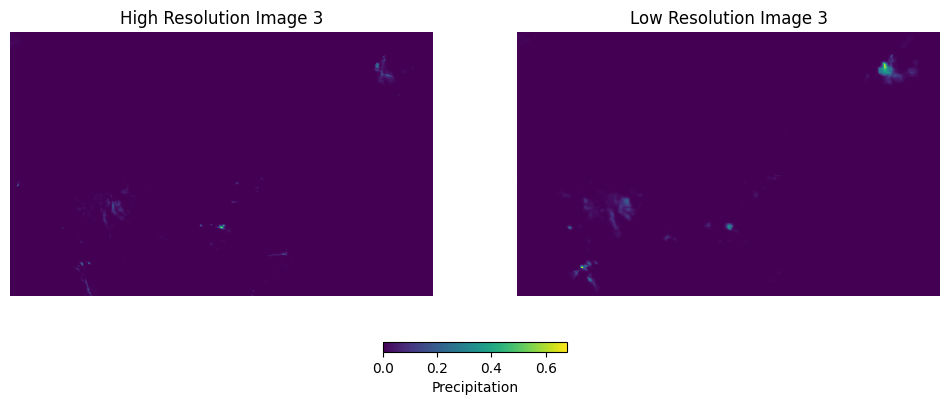

In [13]:
for i in range(test_hr.shape[1]):
    vis(test_hr, test_lr, i)

In [14]:
def calculate_nonzero_pixel_percentage(data):
    batch_size, frame, h, w = data.shape
    data = data.reshape(batch_size * frame, h, w)
    total_pixels_per_image = h * w

    nonzero_pixel_counts = (data != 0).sum(dim=(1, 2)).float()
    
    nonzero_pixel_percentages = nonzero_pixel_counts / total_pixels_per_image
    
    mean_percentage = nonzero_pixel_percentages.mean().item()
    
    return mean_percentage

calculate_nonzero_pixel_percentage(test_hr), calculate_nonzero_pixel_percentage(test_lr)

(0.03729691356420517, 0.08908848464488983)

In [15]:
# if add crop
data_path = '/home/public-workspace/zhouzhiwang/RainNet/newdata/'

# crop=True对分辨率进行裁剪
dataset = RainNetDataset(data_path, frame=4, crop_size_gt=600, is_crop=True,  is_augment=False, rotation=True, flip=True)
len(dataset)

737

In [16]:
loader = data.DataLoader(dataset, batch_size=4, shuffle=False)

for data_hr, data_lr in loader:
    test_hr, test_lr = data_hr, data_lr
    print(data_hr.shape)
    print(data_lr.shape)
    break

torch.Size([4, 4, 600, 600])
torch.Size([4, 4, 200, 200])


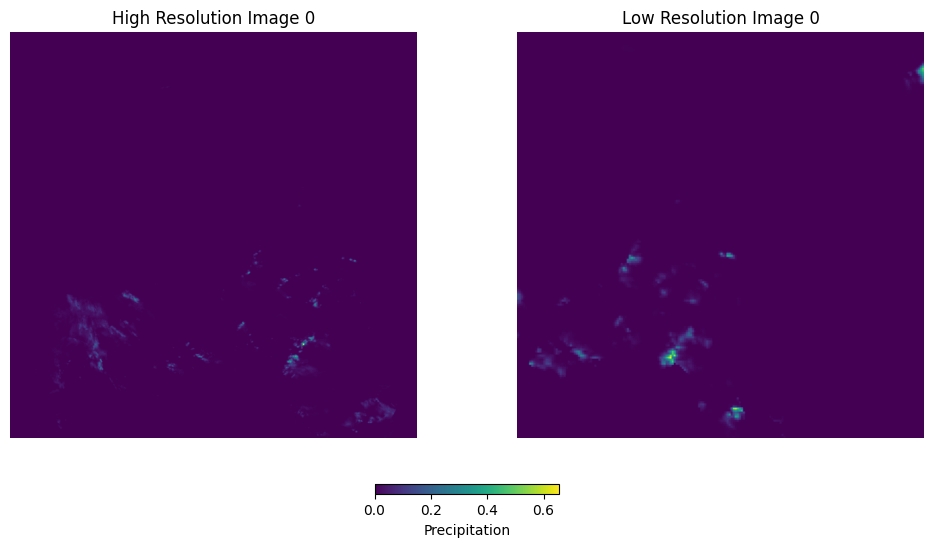

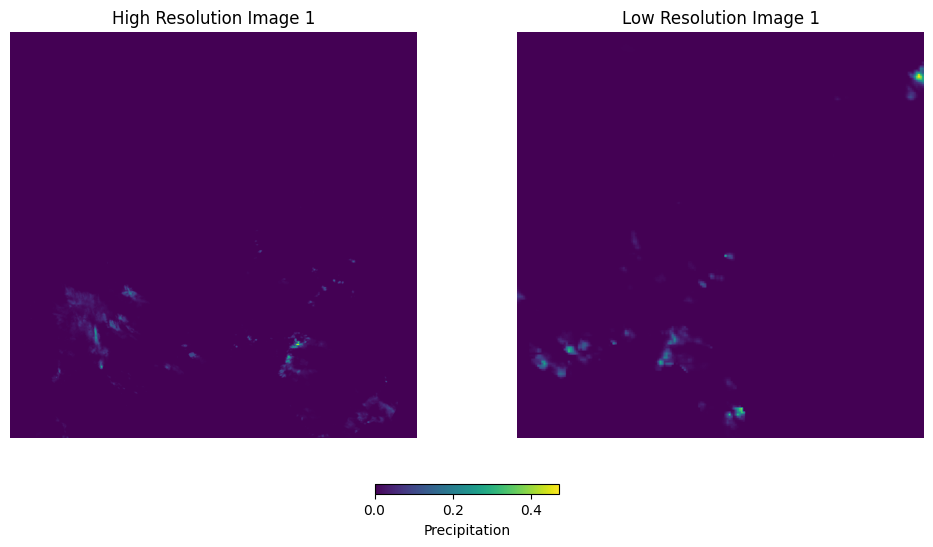

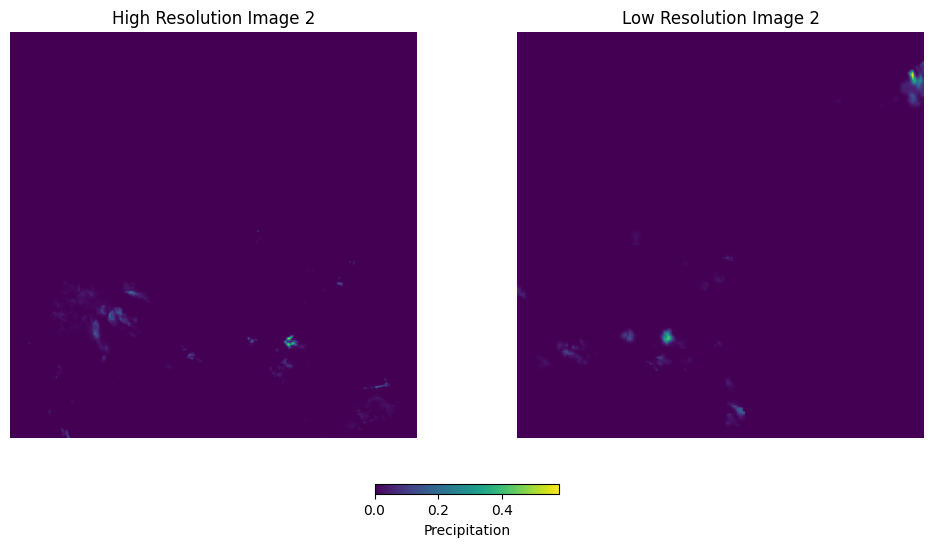

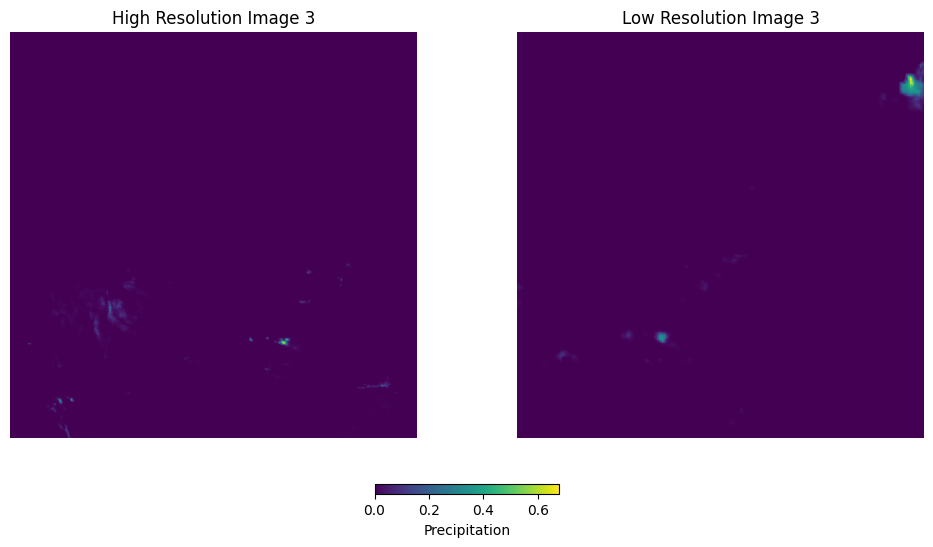

In [17]:
for i in range(test_hr.shape[1]):
    vis(test_hr, test_lr, i)